In [1]:
'''
Problem 1. Consider the same logistic regression example that was solved in "logistic-regression.pdf" (under module 4) using the built-in method fmin_tnc.

(a) Code up your own gradient descent optimizer with backtracking line search. 

(b) Show that your code from part (a) can get very close to the same solution that was found in "logistic-regression.pdf".

(c) Collect the sequence of weight vectors that your descent method uses in each of its steps, and plot them, along with the contours of the loss function,
as we did in module 4, slides 8 and 14. (You do not have to use the same fonts/colours etc. as long as you show the contours, and the steps). 

(d) for the same problem, code up newton's method using the exact Hessian derived in lecture. Show the steps it takes, 
as you did in part (c) for gradient descent. Compare and contrast -- does it converge to the right solution? 
does it take more steps? use less overall time? does adding backtracking line search help or hurt the convergence?

'''


'\nProblem 1. Consider the same logistic regression example that was solved in "logistic-regression.pdf" (under module 4) using the built-in method fmin_tnc.\n\n(a) Code up your own gradient descent optimizer with backtracking line search. \n\n(b) Show that your code from part (a) can get very close to the same solution that was found in "logistic-regression.pdf".\n\n(c) Collect the sequence of weight vectors that your descent method uses in each of its steps, and plot them, along with the contours of the loss function,\nas we did in module 4, slides 8 and 14. (You do not have to use the same fonts/colours etc. as long as you show the contours, and the steps). \n\n(d) for the same problem, code up newton\'s method using the exact Hessian derived in lecture. Show the steps it takes, \nas you did in part (c) for gradient descent. Compare and contrast -- does it converge to the right solution? \ndoes it take more steps? use less overall time? does adding backtracking line search help or h

In [2]:
from cmath import isnan
import math
from turtle import shape
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from scipy.optimize import fmin_tnc

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def prob(theta, x):
    a = np.dot(x, theta)
    return sigmoid(np.dot(x, theta))

def objective(theta, x, y): # Equation in slide 39
    # We calculate the objective function value for all the training set.
    p = prob(theta, x)
    a = np.log(p)
    b = np.log(1-p)
    return - np.sum( y * a + (1 - y) * b)

def bounded_objective(theta, x, y): # Equation in slide 39
    # We calculate the objective function value for all the training set.
    p = prob(theta, x)
    p = np.maximum(p, 0.9999)
    p = np.minimum(p, 0.0001)
    a = np.log(p)
    b = np.log(1-p)
    return - np.sum( y * a + (1 - y) * b)


def gradient(theta, x, y): # From equation (4.8) of slides. xT (mu(w) - y)
    return np.dot(x.T, sigmoid(np.dot(x, theta)) - y)

In [4]:
# Backtrack line search
def backtracking_line_search(x, y, theta, alpha, beta, max_iters=200):
    t = 1
    i = 1

    g = gradient(theta, x, y) 
    a, b = 0, 0
    while a - b >= 0 and i < max_iters+1:
        t *= beta
        a = bounded_objective(theta - t * g, x, y)
        b = bounded_objective(theta , x, y) - alpha * t * np.linalg.norm(g)**2

        #print(f"Iteration {i}: t = {t}, a = {a}, b = {b}, theta = {(theta - t * g).T}  Error: {a - b}")
        i += 1

    return t

In [5]:
def fit_tnc(x, y, theta):
    arr = []

    def callback(xk):
        arr.append(xk)

    return fmin_tnc(func=objective, x0=theta, fprime=gradient, args=(x, y), callback=callback)[0], arr


def fit_gradient_descent(x, y, theta, max_n=10000, alpha=0.4, beta=0.9, epsilon=1e-6):

    thetas = [theta]
    thetas.append(thetas[-1] - backtracking_line_search(x,y,thetas[-1],alpha,beta)*gradient(thetas[-1],x,y))

    i = 0
    while np.linalg.norm(thetas[-1] - thetas[-2]) > epsilon and i < max_n:
        thetas.append(thetas[-1] - backtracking_line_search(x,y,thetas[-1],alpha,beta)*gradient(thetas[-1],x,y))
        i += 1

    return thetas[-1], thetas


# Newton gradient descent
def fit_newton_gradient_descent(x, y, theta, max_n=10000, alpha=0.4, beta=0.9, epsilon=1e-6):

    thetas = [theta]
    i = 0
    start = True
    while start or (np.linalg.norm(thetas[-1] - thetas[-2]) > epsilon and i < max_n):
        mu = prob(theta, x)
        S = np.diag(mu * (1-mu))
        S_inv = np.diag(1 / (mu * (1 - mu)))
        z = np.dot(x, theta) + np.dot(S_inv, y - mu)
        theta = np.dot(np.linalg.inv(np.dot(x.T, np.dot(S,x))),np.dot(x.T,np.dot(S,z)) )
        thetas.append(theta)
        i += 1
        start=False

    return thetas[-1], thetas

In [6]:

def accuracy(x, actual_classes, theta_star):
    predicted_classes = (prob(theta_star, x) >= 0.5).astype(int).flatten()
    return 100 * np.mean(predicted_classes == actual_classes)

def plot_decision_boundary(x, par, admitted, not_admitted):
    x_values = [np.min(x[:, 1] - 5), np.max(x[:, 2] + 5)]
    y_values = - (par[0] + np.dot(par[1], x_values)) / par[2]
    plt.plot(x_values, y_values, label='Decision Boundary')
    plt.scatter(admitted.iloc[:, 0], admitted.iloc[:, 1], s=10, label='Admitted')
    plt.scatter(not_admitted.iloc[:, 0], not_admitted.iloc[:, 1], s=10, label='Not Admitted')
    plt.xlabel('First Exam')
    plt.ylabel('Second Exam')
    plt.legend()
    plt.show()

def get_plot_vectors(X,y, thetas):
    # Prepare data for plots
    w0, w1, w2 = [], [], []
    for _, theta in enumerate(thetas):
        w0.append(theta[0])
        w1.append(theta[1])
        w2.append(theta[2])
    t1 = np.linspace(np.min(w0), np.max(w0), 30)
    t2 = np.linspace(np.min(w1), np.max(w1), 30)
    t3 = np.linspace(np.min(w2), np.max(w2), 30)
    Xm, Ym, Zm = np.meshgrid(t1, t2, t3)

    U = np.zeros((len(t1), len(t2), len(t3)))
    for idx1, theta1 in enumerate(t1):
        for idx2, theta2 in enumerate(t2):
            for idx3, theta3 in enumerate(t3):
                U[idx1][idx2][idx3] = objective([theta1, theta2, theta3],X,y)

    return Xm, Ym, Zm, U

def plot_3d(X,y, thetas):

    Xm, Ym, Zm, U = get_plot_vectors(X,y,thetas)
    # Creating figure
    fig = plt.figure()

    ax = plt.axes(projection="3d")

    # Creating plot
    img = ax.scatter3D(Xm, Ym, Zm, c=U, alpha=0.05, cmap=plt.hot(),  marker='.')
    fig.colorbar(img)

    for i, weights in enumerate(thetas):
        if i >= 1:
            ax.plot3D([last_weights[0], weights[0]], [last_weights[1], weights[1]], [last_weights[2], weights[2]], 'blue')
            ax.text(*weights, f"step {i}", rotation=45)
        else:
            ax.text(*weights, "start", rotation=45)
        last_weights = weights
    ax.set_xlabel("W0")
    ax.set_ylabel("W1")
    ax.set_zlabel("W2")

    plt.show()

In [7]:
data = pd.read_csv("marks.txt")

X = data.iloc[:, :-1]
X = np.c_[np.ones((X.shape[0], 1)), X] ## augment with column of ones

# y = target values, last column of the data frame
y = data.iloc[:, -1].to_numpy()

admitted = data.loc[y == 1]
not_admitted = data.loc[y == 0]

In [8]:
theta_star, thetas_tnc = fit_tnc(X, y, np.zeros((X.shape[1], 1)))
print(f"theta_star: {theta_star}") 
print(f"thetas_tnc: {thetas_tnc}") 

theta_star: [-24.8687714    0.20337239   0.19987264]
thetas_tnc: [array([4.67838005e-05, 5.42796119e-03, 5.19209544e-03]), array([-0.01026403,  0.00674088,  0.00533615]), array([-0.41062997,  0.02400047, -0.00618713]), array([-0.42016984,  0.02311659, -0.00640795]), array([-10.41958369,   0.08213761,   0.08436161]), array([-10.97661176,   0.09617729,   0.07952693]), array([-10.92110649,   0.09675288,   0.08277289]), array([-10.92125192,   0.0934887 ,   0.08710768]), array([-10.92487547,   0.09176149,   0.08784726]), array([-21.05826325,   0.17366891,   0.177915  ]), array([-22.9980266 ,   0.18015801,   0.1951089 ]), array([-24.75183754,   0.200663  ,   0.20009405]), array([-24.88521942,   0.20281941,   0.20088883]), array([-25.02128873,   0.2044508 ,   0.20125433]), array([-25.02128742,   0.20459694,   0.20110222]), array([-25.01851757,   0.20458507,   0.20109149]), array([-24.8687714,   0.2033723,   0.1998726]), array([-24.8687714 ,   0.20337239,   0.19987264])]


  NIT   NF   F                       GTG
    0    1  6.862157087543459E+01   2.84211917E+06
tnc: fscale = 0.00059317
    1    3  6.214125236320825E+01   7.20777565E+03
    2    5  6.205441634496405E+01   1.08733524E+04
    3    7  6.036224280724579E+01   1.62164972E+04
    4    9  6.029361349436471E+01   3.56463504E+04
tnc: stepmx = 1000
    5   12  2.713207048425929E+01   1.46059256E+05
    6   14  2.650334513225379E+01   1.13146382E+05
    7   16  2.592473040380308E+01   1.62903259E+03
tnc: fscale = 0.0247762
    8   18  2.581417416367718E+01   4.36850216E+03
    9   20  2.577978670491390E+01   3.31832306E+01
   10   25  2.176338924238604E+01   1.26548050E+05
   11   27  2.063852197641238E+01   4.87609992E+03
   12   29  2.026414930916156E+01   5.95154745E+02
   13   31  2.025353325582831E+01   4.17615832E+01
   14   33  2.025159657522656E+01   4.84666471E-01
tnc: fscale = 1.43641
   15   35  2.025152316046627E+01   2.82555103E-03
   16   37  2.025151734952087E+01   6.21764043E-01
  

accuracy: 88.89%


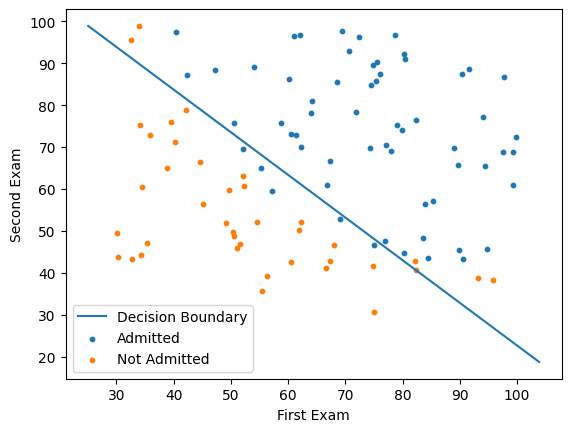

/tmp/ipykernel_52784/1103109471.py:12: RuntimeWarning: divide by zero encountered in log
  b = np.log(1-p)
/tmp/ipykernel_52784/1103109471.py:13: RuntimeWarning: invalid value encountered in multiply
  return - np.sum( y * a + (1 - y) * b)


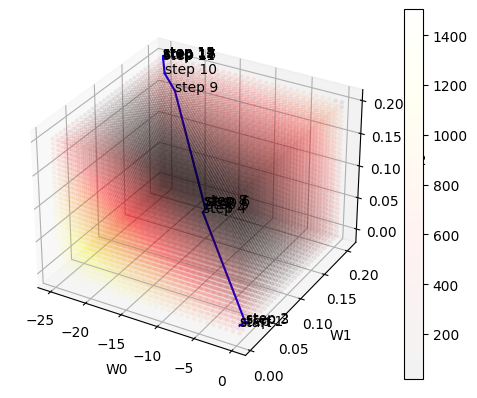

In [9]:
print(f"accuracy: {accuracy(X, y, theta_star):.2f}%")
plot_decision_boundary(X, theta_star, admitted, not_admitted)
plot_3d(X,y,thetas_tnc)

In [10]:
alphas = np.linspace(0.01, 0.49, 10)
betas = np.linspace(0.01, 0.99, 10)

theta_star_backtrack_best_objective = np.Inf
theta_star_backtrack = []
thetas_backtrack = [[]]
for alpha in alphas:
    for beta in betas:
        theta_star_backtrack_aux, thetas_backtrack_aux = fit_gradient_descent(X, y, np.array([-25,0.2,0.2]),alpha, beta)
        obj = objective(theta_star_backtrack_aux,X,y)
        if obj < theta_star_backtrack_best_objective:
            theta_star_backtrack_best_objective = obj
            theta_star_backtrack = theta_star_backtrack_aux
            thetas_backtrack = thetas_backtrack_aux

print(f"theta_star_backtrack: {theta_star_backtrack}")
print(f"thetas: {thetas_backtrack}")

theta_star_backtrack: [-25.           0.2000001    0.20000009]
thetas: [array([-25. ,   0.2,   0.2]), array([-25.        ,   0.2000001 ,   0.20000009])]


accuracy: 89.90%


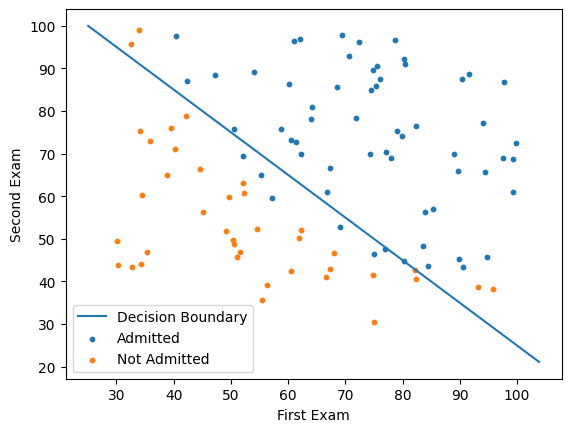

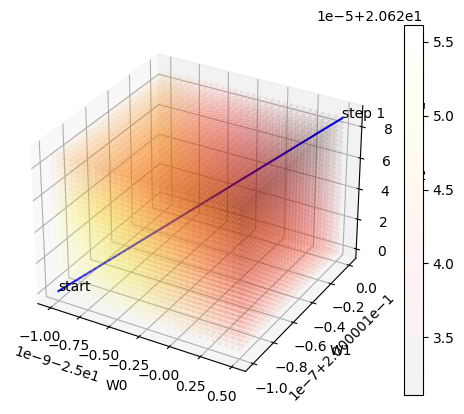

In [11]:
print(f"accuracy: {accuracy(X, y, theta_star_backtrack):.2f}%")
plot_decision_boundary(X, theta_star_backtrack, admitted, not_admitted)
plot_3d(X,y,thetas_backtrack)

In [12]:
alphas = np.linspace(0.01, 0.49, 10)
betas = np.linspace(0.01, 0.99, 10)

theta_star_newton_best_objective = np.Inf
theta_star_newton = []
thetas_newton = [[]]
for alpha in alphas:
    for beta in betas:
        theta_star_newton_aux, thetas_newton_aux = fit_newton_gradient_descent(X, y, np.array([0,0,0]), alpha, beta)
        obj = objective(theta_star_newton_aux,X,y)
        if obj < theta_star_newton_best_objective:
            theta_star_newton_best_objective = obj
            theta_star_newton = theta_star_newton_aux
            thetas_newton = thetas_newton_aux

print(f"theta_star_newton: {theta_star_newton}")
print(f"thetas: {thetas_newton}")

theta_star_newton: [-7.13638166  0.05832469  0.05618019]
thetas: [array([0, 0, 0]), array([-7.13638166,  0.05832469,  0.05618019])]


accuracy: 89.90%


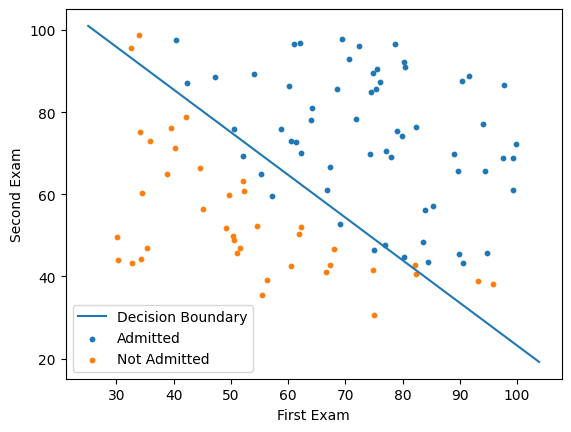

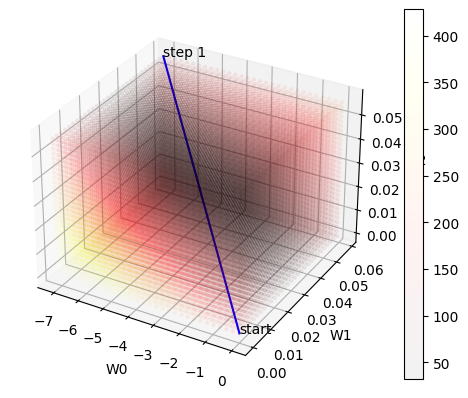

In [13]:
print(f"accuracy: {accuracy(X, y, theta_star_newton):.2f}%")
plot_decision_boundary(X, theta_star_newton, admitted, not_admitted)
plot_3d(X,y, thetas_newton)

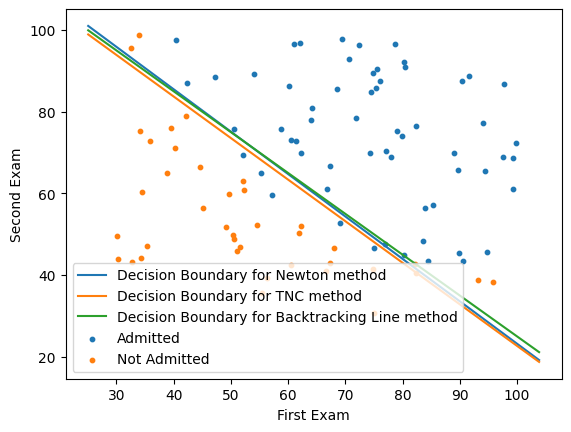

In [15]:
# par dict is a dictionary that has method -> values
def plot_decision_boundary_comparison(x, par_dict, admitted, not_admitted):
    for k, v in par_dict.items():
        x_values = [np.min(x[:, 1] - 5), np.max(x[:, 2] + 5)]
        y_values = - (v[0] + np.dot(v[1], x_values)) / v[2]
        plt.plot(x_values, y_values, label=f"Decision Boundary for {k} method")
    plt.scatter(admitted.iloc[:, 0], admitted.iloc[:, 1], s=10, label='Admitted')
    plt.scatter(not_admitted.iloc[:, 0], not_admitted.iloc[:, 1], s=10, label='Not Admitted')
    plt.xlabel('First Exam')
    plt.ylabel('Second Exam')
    plt.legend()
    plt.show()

par_dict = {
    "Newton": theta_star_newton,
    "TNC": theta_star,
    "Backtracking Line": theta_star_backtrack
}

plot_decision_boundary_comparison(X, par_dict, admitted, not_admitted)